# LIS Cheating - Regression Modeling Revision, Follow-Up

Andrew Chung, hc893, 02/19/2025

Points from Today

- Logistic Model may not be feasible, as the goal is to directly map the linear combination to the actual labels
- Try fixed coefficients: $\beta_\text{pDockQ} = 0.4, \beta_\text{ipTM} = 0.3, \beta_\text{LIS} = 0.3$
- Optionally, apply constraint $\sum \beta = 1$ to ensure the summed metric falls within $[0,1]$, or apply min-max scaling

In [28]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
  roc_curve, 
  auc, roc_auc_score, 
  precision_recall_curve, 
  average_precision_score
)

Import AF3 PPI Prediction Data

In [29]:
af3 = pd.read_csv("af3_metric_experiments.csv")[[
  'ppi', 'SC_LIS', 'SLIRS', 'ICS_bin', 'ICS_log', 'LIS', 'PWID', 
  'LIP', 'pDockQ', 'ipTM', 'pdockq2_mean', 'ranking_confidence', 'ZIES',
  'non_struct_label', 'str_label'
]]
# coerce type np.int64
af3[['non_struct_label', 'str_label']] = af3[['non_struct_label', 'str_label']].astype(np.int64)

# filter for ground truth variables (1 = HINT-binary-HQ-LC, 0 = non-interacting pairs); remove -1
nonstr_ = af3[af3['non_struct_label'] > -1].drop(columns = ['str_label']).rename(columns = {'non_struct_label': 'label'})
str_ = af3[af3['str_label'] > -1].drop(columns = ['non_struct_label']).rename(columns = {'str_label': 'label'})

## Method 1: Fixed Coefficients

$$a = 0.4, b = 0.3, c = 0.3$$

### Non-Structural

In [30]:
X_ns = nonstr_[['pDockQ', 'ipTM', 'LIS']].to_numpy()
b_ns = np.array([0.4,0.3,0.3])
nonstr_['model'] = np.matmul(X_ns, b_ns.T)

AUC for LIS: 0.7020364397306882
AUC for model: 0.7024049961545481


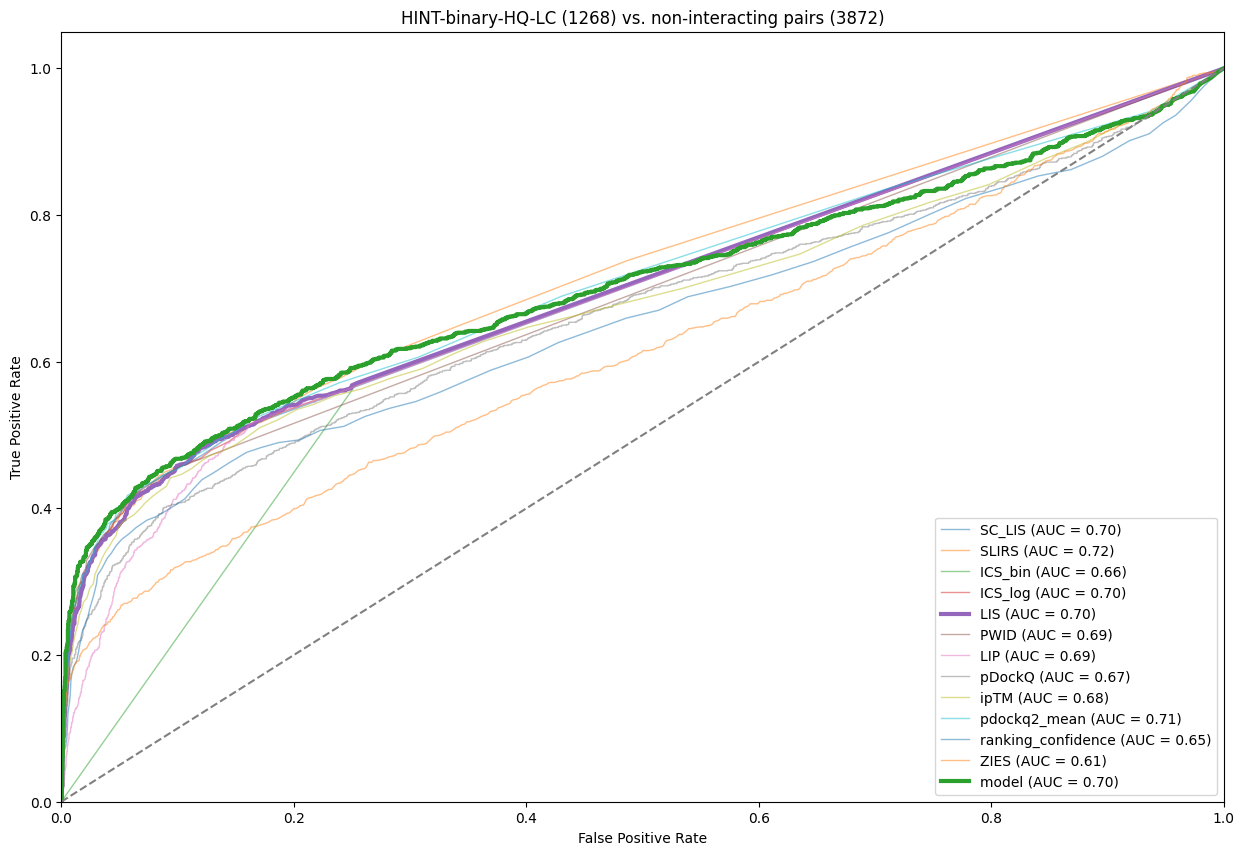

In [31]:
y_true = nonstr_['label']  # Binary response (0 or 1)

# Multiple predictors (scaled 0-1)
predictors = {
  metric : nonstr_[metric] for metric in np.array(nonstr_.columns) if metric not in ['ppi', 'label']
}

plt.figure(figsize=(15,10))

# Plot ROC curves for each predictor
for label, y_score in predictors.items():
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 
      lw= 3 if label in ['model', 'LIS'] else 1, 
      alpha = 1 if label in ['model', 'LIS'] else 0.5, 
      label=f'{label} (AUC = {roc_auc:.2f})'
    )
    if label in ['model', 'LIS']:
      print("AUC for {}: {}".format(label, roc_auc))

# Plot reference line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('HINT-binary-HQ-LC ({}) vs. non-interacting pairs ({})'.format(
  (nonstr_['label'] == 1).sum(), (nonstr_['label'] == 0).sum()
))
plt.legend(loc='lower right')
plt.show()

PR for LIS: 0.5481150021242001
PR for model: 0.5935716790360245


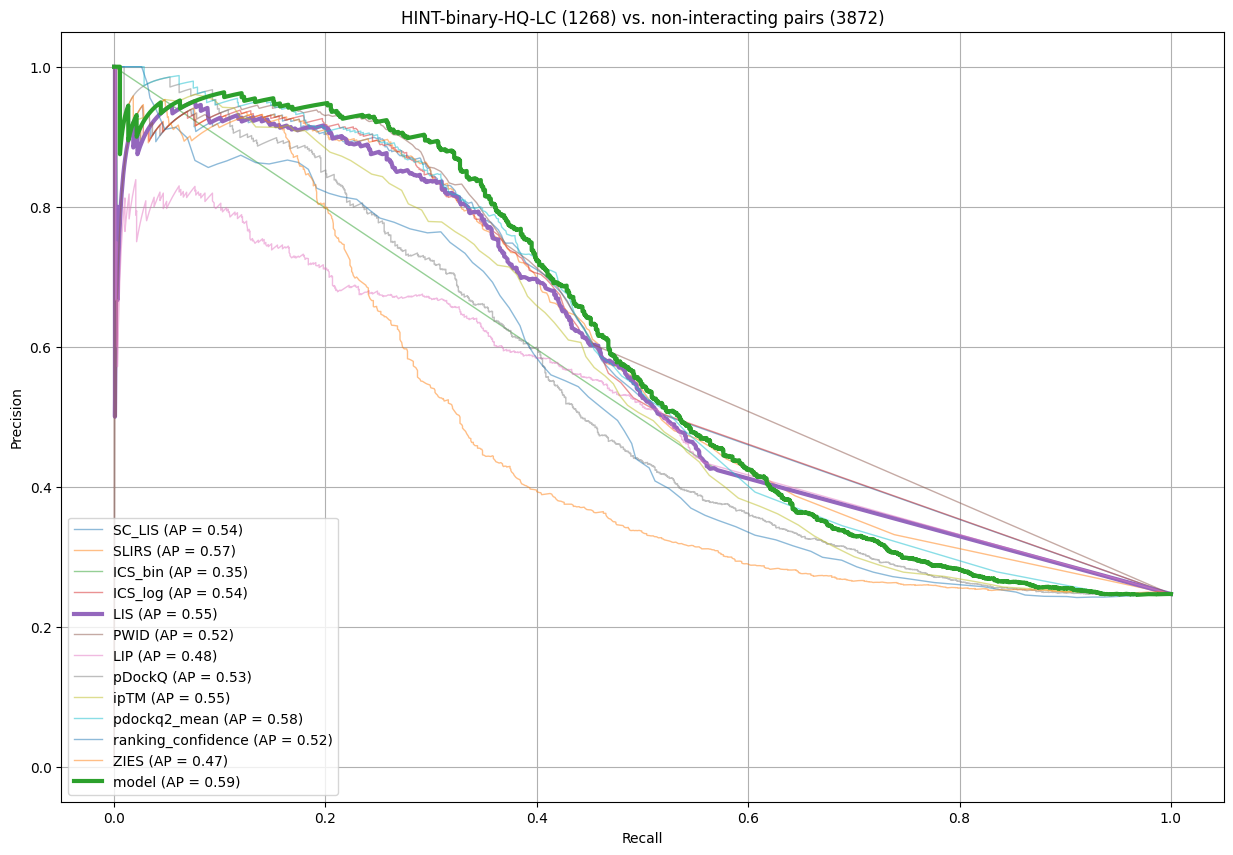

In [32]:
y_true = nonstr_['label']
plt.figure(figsize = (15,10))

for label, y_score in predictors.items():
  precision, recall, _ = precision_recall_curve(y_true, y_score)
  avg_precision = average_precision_score(y_true, y_score)
  plt.plot(recall, precision, 
    lw= 3 if label in ['model', 'LIS'] else 1, 
    alpha = 1 if label in ['model', 'LIS'] else 0.5, 
    label=f'{label} (AP = {avg_precision:.2f})'
  )

  if label in ['model', 'LIS']:
      print("PR for {}: {}".format(label, avg_precision))

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('HINT-binary-HQ-LC ({}) vs. non-interacting pairs ({})'.format(
  (nonstr_['label'] == 1).sum(), (nonstr_['label'] == 0).sum()
))
plt.legend(loc="lower left")
plt.grid(True)

# Show the plot
plt.show()

### Structural

In [33]:
X_s = str_[['pDockQ', 'ipTM', 'LIS']].to_numpy()
b_s = np.array([0.4,0.3,0.3])
str_['model'] = np.matmul(X_s, b_s.T)

AUC for LIS: 0.7618160363884436
AUC for model: 0.8265228923234095


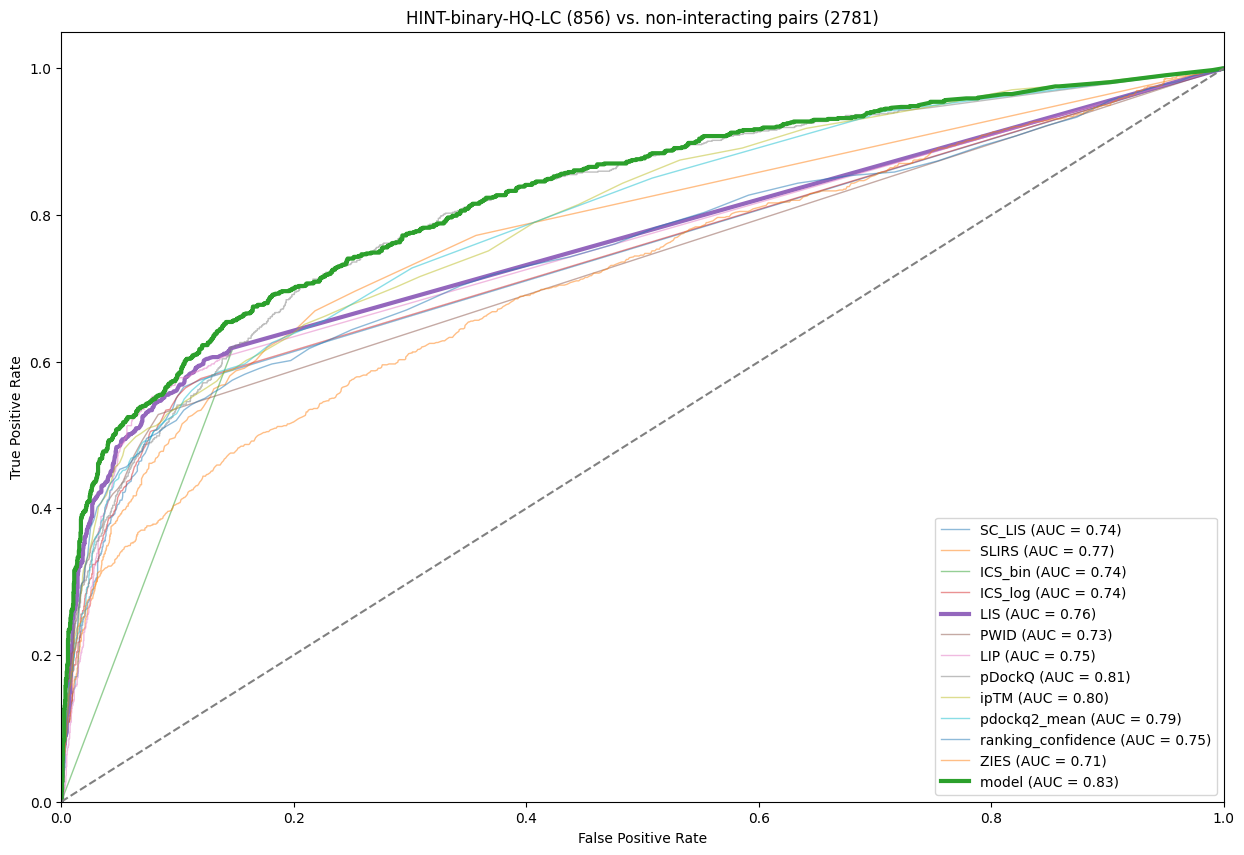

In [34]:
y_true = str_['label']  # Binary response (0 or 1)

# Multiple predictors (scaled 0-1)
predictors = {
  metric : str_[metric] for metric in np.array(str_.columns) if metric not in ['ppi', 'label']
}

plt.figure(figsize=(15,10))

# Plot ROC curves for each predictor
for label, y_score in predictors.items():
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 
      lw= 3 if label in ['model', 'LIS'] else 1, 
      alpha = 1 if label in ['model', 'LIS'] else 0.5, 
      label=f'{label} (AUC = {roc_auc:.2f})'
    )

    if label in ['model', 'LIS']:
      print("AUC for {}: {}".format(label, roc_auc))

# Plot reference line
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('HINT-binary-HQ-LC ({}) vs. non-interacting pairs ({})'.format(
  (str_['label'] == 1).sum(), (str_['label'] == 0).sum()
))
plt.legend(loc='lower right')
plt.show()

PR for LIS: 0.5919297527848006
PR for model: 0.684725922214973


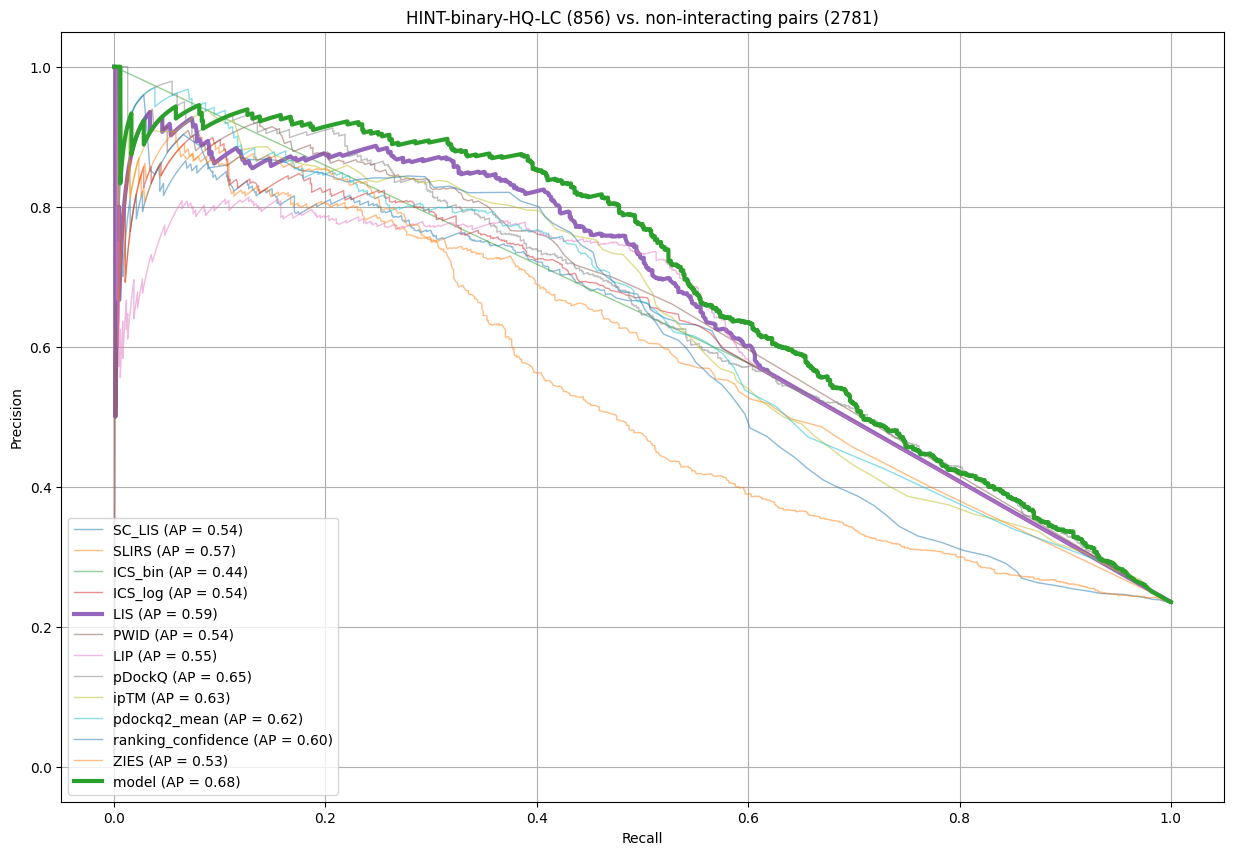

In [35]:
y_true = str_['label']
plt.figure(figsize = (15,10))

for label, y_score in predictors.items():
  precision, recall, _ = precision_recall_curve(y_true, y_score)
  avg_precision = average_precision_score(y_true, y_score)
  plt.plot(recall, precision, 
    lw= 3 if label in ['model', 'LIS'] else 1, 
    alpha = 1 if label in ['model', 'LIS'] else 0.5, 
    label=f'{label} (AP = {avg_precision:.2f})'
  )
  if label in ['model', 'LIS']:
      print("PR for {}: {}".format(label, avg_precision))

# Labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('HINT-binary-HQ-LC ({}) vs. non-interacting pairs ({})'.format(
  (str_['label'] == 1).sum(), (str_['label'] == 0).sum()
))
plt.legend(loc="lower left")
plt.grid(True)

# Show the plot
plt.show()